# Introduction

A store wants to predict store sales per product family per store, with a certain promotion status.

In this competition we need to build a machine learning pipeline to achieve that task.

We have the following information:
- Test (the product family, store, and promotion status) we want to predict
- Train (the past product family, store, and promotion status) and the sales the store managed to achieve.
- Additional tables, containing context available and relevant both for past sales, and for future sales. For example additional store details. 


In [124]:
#Train and test share: date, store_nbr, family(product_family), onpromotion (number of products of the family that were on promotion)
#Train also has the sales.
#Test is what we are trying to predict in the competition

#Stores contains store metadata, we might want to join that data into our train and test tables to improve predictions if they are not redundant with the store_nbr (aka if at least some of the stores share their values).
 #stores metadata
#type and cluster are not redundant. see stores_df[['type', 'cluster']].drop_duplicates()#.pivot(columns='cluster')

#Daily oil price, keep in mind oil price affects ecuador economical health.
#We probably want to join it into our dataframe, but keep in mind it seems to have some null values. We probably want to fill downwards so that it takes its value from the previous date but well have to see. We could also average between the next and previous day.


#While its not clear it seems to be the total transactions of the store on that day


#A table containing holiday events. 
#its worth noting that some events were transfered in date so we need to take into account hte actual date. transfered column True means that the holiday wasnt actually celebrated that date.
#Also, keep in mind that some seem to be regional and some local. This could mean that we need to take into account the region in considering them.
#Some special_days were of type bridge, meaning  they are extra days added to the same holiday.
#This are often compensated by making some not working days(ie saturday) working days. This are of type workday.
#holiday_type additional means that it isnt an actual holiday, but actually the extension of one.

#Additonally to these tables wages on the public sector are paid on the 15th and last day of each month which could affect supermarket sales
#A great earthquiake struck ecuador on april 16 2016 which resulted in donations possibly affecting sales.


#TLDR we need to add many features to the train and test df.
#First lets make some column names easier to understand. Specially after joining.

[autoreload of data_preparation_attempt3 failed: Traceback (most recent call last):
  File "c:\Users\uriel.salvio\Documents\Python Projects\ML examples\TimeSeriesForecastStoreSales\.venv\Lib\site-packages\IPython\extensions\autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "c:\Users\uriel.salvio\Documents\Python Projects\ML examples\TimeSeriesForecastStoreSales\.venv\Lib\site-packages\IPython\extensions\autoreload.py", line 475, in superreload
    module = reload(module)
             ^^^^^^^^^^^^^^
  File "C:\Program Files\Python311\Lib\importlib\__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 621, in _exec
  File "<frozen importlib._bootstrap_external>", line 940, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "c:\Users\uriel.salvio\Documents\Python Projects\ML examples\TimeSeriesForecastStoreSales\data_preparation_attempt3.py", l

In [125]:
import pandas as pd
import data_preparation_attempt3 as data_prep
from data_preparation_attempt3 import TimeSeriesForecastDataframes
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import numpy as np

In [126]:
#Reload all modules imported with %aimport every time before executing the Python code typed. https://ipython.readthedocs.io/en/stable/config/extensions/autoreload.html
%load_ext autoreload
%autoreload explicit
%aimport data_preparation_attempt3

pd.set_option('display.max_rows', 3000)
pd.set_option('display.max_columns',1000)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Prepare the dataset for the pipeline

In [128]:
entire_dataframes = data_prep.get_feature_dfs()

#The dataframe for training, and crossvalidation
cross_val_dataframes:TimeSeriesForecastDataframes = TimeSeriesForecastDataframes(entire_dataframes.base_xy_df[:50000],
                                                                                entire_dataframes.stores_df,
                                                                                entire_dataframes.oil_df,
                                                                                entire_dataframes.transactions_df,
                                                                                entire_dataframes.special_days_df)

merging_pipeline = data_prep.create_merging_pipeline()
all_features:pd.DataFrame = merging_pipeline.fit_transform(cross_val_dataframes)

window_size = 5
pipeline = data_prep.create_pipeline(window_size, verbose=True) 

cross_val_results = cross_validate(pipeline, all_features, all_features['sales'], cv=TimeSeriesSplit(n_splits=5),error_score='raise',
                                   return_indices=False, return_estimator=False, return_train_score=True)
                                   

display(cross_val_results['train_score'])
display(cross_val_results['test_score'])

display(np.average(cross_val_results['train_score']))
display(np.average(cross_val_results['test_score']))

[Pipeline]  (step 1 of 8) Processing fill_missing_oil_values, total=   0.0s
[Pipeline]  (step 2 of 8) Processing fill_missing_transactions, total=   0.0s
[Pipeline]  (step 3 of 8) Processing refine_special_day_reason, total=   0.0s
[Pipeline]  (step 4 of 8) Processing replace_date_with_date_related_columns, total=   0.0s
[Pipeline] .. (step 5 of 8) Processing prepare_features, total=   8.1s
[Pipeline] .... (step 6 of 8) Processing window_dataset, total=   0.5s
[Pipeline] ....... (step 7 of 8) Processing drop_target, total=   0.0s
[Pipeline] ............. (step 8 of 8) Processing model, total=   1.9s
[Pipeline]  (step 1 of 8) Processing fill_missing_oil_values, total=   0.0s
[Pipeline]  (step 2 of 8) Processing fill_missing_transactions, total=   0.0s
[Pipeline]  (step 3 of 8) Processing refine_special_day_reason, total=   0.1s
[Pipeline]  (step 4 of 8) Processing replace_date_with_date_related_columns, total=   0.0s
[Pipeline] .. (step 5 of 8) Processing prepare_features, total=   1.5s

array([0.5559754 , 0.57023668, 0.59899458, 0.61403497, 0.61446357])

array([-6.38263450e+15, -1.73188389e+14, -9.57927080e+15,  6.18300756e-01,
        6.78957465e-01])

0.5907410400258568

-3227018737202953.5

c:\Users\uriel.salvio\Documents\Python Projects\ML examples\TimeSeriesForecastStoreSales\data_preparation_attempt3.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_df['oil_price'] = features_df['oil_price'].ffill()#.fillna(method='ffill')
c:\Users\uriel.salvio\Documents\Python Projects\ML examples\TimeSeriesForecastStoreSales\data_preparation_attempt3.py:178: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_df['oil_price'] = features_df['oil_price'].bfill() #Make sure that if the first e

[Pipeline]  (step 1 of 8) Processing fill_missing_oil_values, total=   0.0s
[Pipeline]  (step 2 of 8) Processing fill_missing_transactions, total=   0.0s
[Pipeline]  (step 3 of 8) Processing refine_special_day_reason, total=   0.1s


c:\Users\uriel.salvio\Documents\Python Projects\ML examples\TimeSeriesForecastStoreSales\data_preparation_attempt3.py:242: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_df['day_of_year'] = features_df['date'].dt.dayofyear
c:\Users\uriel.salvio\Documents\Python Projects\ML examples\TimeSeriesForecastStoreSales\data_preparation_attempt3.py:243: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_df['day_of_month'] = features_df['date'].dt.day
c:\Users\uriel.salvio\Documents\Python Projects\ML exam

[Pipeline]  (step 4 of 8) Processing replace_date_with_date_related_columns, total=   0.1s
[Pipeline] .. (step 5 of 8) Processing prepare_features, total=   5.9s
[Pipeline] .... (step 6 of 8) Processing window_dataset, total=   0.4s
[Pipeline] ....... (step 7 of 8) Processing drop_target, total=   0.0s
[Pipeline] ............. (step 8 of 8) Processing model, total=   1.8s


c:\Users\uriel.salvio\Documents\Python Projects\ML examples\TimeSeriesForecastStoreSales\data_preparation_attempt3.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_df['oil_price'] = features_df['oil_price'].ffill()#.fillna(method='ffill')
c:\Users\uriel.salvio\Documents\Python Projects\ML examples\TimeSeriesForecastStoreSales\data_preparation_attempt3.py:178: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_df['oil_price'] = features_df['oil_price'].bfill() #Make sure that if the first e

[Pipeline]  (step 1 of 8) Processing fill_missing_oil_values, total=   0.0s
[Pipeline]  (step 2 of 8) Processing fill_missing_transactions, total=   0.0s
[Pipeline]  (step 3 of 8) Processing refine_special_day_reason, total=   0.0s
[Pipeline]  (step 4 of 8) Processing replace_date_with_date_related_columns, total=   0.0s
[Pipeline] .. (step 5 of 8) Processing prepare_features, total=   0.8s
[Pipeline] .... (step 6 of 8) Processing window_dataset, total=   0.6s
[Pipeline] ....... (step 7 of 8) Processing drop_target, total=   0.0s
[Pipeline] ............. (step 8 of 8) Processing model, total=   2.6s


c:\Users\uriel.salvio\Documents\Python Projects\ML examples\TimeSeriesForecastStoreSales\data_preparation_attempt3.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_df['oil_price'] = features_df['oil_price'].ffill()#.fillna(method='ffill')
c:\Users\uriel.salvio\Documents\Python Projects\ML examples\TimeSeriesForecastStoreSales\data_preparation_attempt3.py:178: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_df['oil_price'] = features_df['oil_price'].bfill() #Make sure that if the first e

[Pipeline]  (step 1 of 8) Processing fill_missing_oil_values, total=   0.0s
[Pipeline]  (step 2 of 8) Processing fill_missing_transactions, total=   0.0s
[Pipeline]  (step 3 of 8) Processing refine_special_day_reason, total=   0.0s
[Pipeline]  (step 4 of 8) Processing replace_date_with_date_related_columns, total=   0.0s
[Pipeline] .. (step 5 of 8) Processing prepare_features, total=   0.7s
[Pipeline] .... (step 6 of 8) Processing window_dataset, total=   1.2s
[Pipeline] ....... (step 7 of 8) Processing drop_target, total=   0.0s
[Pipeline] ............. (step 8 of 8) Processing model, total=   4.3s


c:\Users\uriel.salvio\Documents\Python Projects\ML examples\TimeSeriesForecastStoreSales\data_preparation_attempt3.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_df['oil_price'] = features_df['oil_price'].ffill()#.fillna(method='ffill')
c:\Users\uriel.salvio\Documents\Python Projects\ML examples\TimeSeriesForecastStoreSales\data_preparation_attempt3.py:178: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_df['oil_price'] = features_df['oil_price'].bfill() #Make sure that if the first e

[Pipeline]  (step 1 of 8) Processing fill_missing_oil_values, total=   0.0s
[Pipeline]  (step 2 of 8) Processing fill_missing_transactions, total=   0.0s


c:\Users\uriel.salvio\Documents\Python Projects\ML examples\TimeSeriesForecastStoreSales\data_preparation_attempt3.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_df['special_day_reason'] = features_df['special_day_reason'].apply(process_special_day_reason_value)
c:\Users\uriel.salvio\Documents\Python Projects\ML examples\TimeSeriesForecastStoreSales\data_preparation_attempt3.py:233: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_df['date'] = pd.to_datetime(features_df['date'],format=

[Pipeline]  (step 3 of 8) Processing refine_special_day_reason, total=   0.3s
[Pipeline]  (step 4 of 8) Processing replace_date_with_date_related_columns, total=   0.2s
[Pipeline] .. (step 5 of 8) Processing prepare_features, total=   1.3s
[Pipeline] .... (step 6 of 8) Processing window_dataset, total=   2.1s
[Pipeline] ....... (step 7 of 8) Processing drop_target, total=   0.0s
[Pipeline] ............. (step 8 of 8) Processing model, total=   4.6s


c:\Users\uriel.salvio\Documents\Python Projects\ML examples\TimeSeriesForecastStoreSales\data_preparation_attempt3.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_df['oil_price'] = features_df['oil_price'].ffill()#.fillna(method='ffill')
c:\Users\uriel.salvio\Documents\Python Projects\ML examples\TimeSeriesForecastStoreSales\data_preparation_attempt3.py:178: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_df['oil_price'] = features_df['oil_price'].bfill() #Make sure that if the first e

[Pipeline]  (step 1 of 8) Processing fill_missing_oil_values, total=   0.0s
[Pipeline]  (step 2 of 8) Processing fill_missing_transactions, total=   0.0s
[Pipeline]  (step 3 of 8) Processing refine_special_day_reason, total=   0.0s
[Pipeline]  (step 4 of 8) Processing replace_date_with_date_related_columns, total=   0.0s
[Pipeline] .. (step 5 of 8) Processing prepare_features, total=   1.1s
[Pipeline] .... (step 6 of 8) Processing window_dataset, total=   2.2s
[Pipeline] ....... (step 7 of 8) Processing drop_target, total=   0.1s
[Pipeline] ............. (step 8 of 8) Processing model, total=   5.9s


c:\Users\uriel.salvio\Documents\Python Projects\ML examples\TimeSeriesForecastStoreSales\data_preparation_attempt3.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_df['oil_price'] = features_df['oil_price'].ffill()#.fillna(method='ffill')
c:\Users\uriel.salvio\Documents\Python Projects\ML examples\TimeSeriesForecastStoreSales\data_preparation_attempt3.py:178: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_df['oil_price'] = features_df['oil_price'].bfill() #Make sure that if the first e

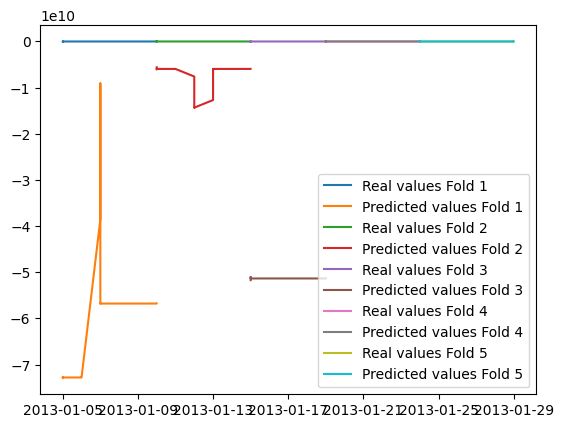

In [72]:
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd

# Convert the date column to datetime
all_features['date'] = pd.to_datetime(all_features['date'], format='%Y-%M-%d')

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

fig, ax = plt.subplots()

# For each split train the model and plot the real and predicted values
for i, (train_index, test_index) in enumerate(tscv.split(all_features)):
    train, test = all_features.iloc[train_index], all_features.iloc[test_index]
    
    # Fit the pipeline on the training data
    pipeline.fit(train, train['sales'])
    
    # Predict the sales on the test data
    predictions = pipeline.predict(test)
    
    # Plot the real and predicted values
    ax.plot(test['date'], test['sales'], label=f'Real values Fold {i+1}')
    ax.plot(test['date'], predictions, label=f'Predicted values Fold {i+1}')

plt.legend()
plt.show()


In [116]:
entire_dataframes = data_prep.get_feature_dfs()

#The dataframe for training, and crossvalidation
cross_val_dataframes:TimeSeriesForecastDataframes = TimeSeriesForecastDataframes(entire_dataframes.base_xy_df[:500000],
                                                                                entire_dataframes.stores_df,
                                                                                entire_dataframes.oil_df,
                                                                                entire_dataframes.transactions_df,
                                                                                entire_dataframes.special_days_df)

merging_pipeline = data_prep.create_merging_pipeline()
all_features:pd.DataFrame = merging_pipeline.fit_transform(cross_val_dataframes)

In [121]:
all_features.columns

Index(['date', 'store_nbr', 'product_family', 'sales',
       'products_of_family_on_promotion', 'oil_price', 'store_city',
       'store_state', 'store_type', 'store_cluster', 'day_type',
       'special_day_locale_type', 'special_day_locale', 'special_day_reason',
       'special_day_transferred', 'all_products_transactions',
       'days_since_start'],
      dtype='object')

c:\Users\uriel.salvio\Documents\Python Projects\ML examples\TimeSeriesForecastStoreSales\data_preparation_attempt3.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_df['oil_price'] = features_df['oil_price'].ffill()#.fillna(method='ffill')
c:\Users\uriel.salvio\Documents\Python Projects\ML examples\TimeSeriesForecastStoreSales\data_preparation_attempt3.py:178: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_df['oil_price'] = features_df['oil_price'].bfill() #Make sure that if the first e

[Pipeline]  (step 1 of 8) Processing fill_missing_oil_values, total=   0.0s
[Pipeline]  (step 2 of 8) Processing fill_missing_transactions, total=   0.0s
[Pipeline]  (step 3 of 8) Processing refine_special_day_reason, total=   0.0s
[Pipeline]  (step 4 of 8) Processing replace_date_with_date_related_columns, total=   0.0s
[Pipeline] .. (step 5 of 8) Processing prepare_features, total=   4.1s
[Pipeline] .... (step 6 of 8) Processing window_dataset, total=   0.8s
[Pipeline] ....... (step 7 of 8) Processing drop_target, total=   0.0s
[Pipeline] ............. (step 8 of 8) Processing model, total=   1.6s


c:\Users\uriel.salvio\Documents\Python Projects\ML examples\TimeSeriesForecastStoreSales\data_preparation_attempt3.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_df['oil_price'] = features_df['oil_price'].ffill()#.fillna(method='ffill')
c:\Users\uriel.salvio\Documents\Python Projects\ML examples\TimeSeriesForecastStoreSales\data_preparation_attempt3.py:178: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_df['oil_price'] = features_df['oil_price'].bfill() #Make sure that if the first e

[Pipeline]  (step 1 of 8) Processing fill_missing_oil_values, total=   0.0s
[Pipeline]  (step 2 of 8) Processing fill_missing_transactions, total=   0.0s
[Pipeline]  (step 3 of 8) Processing refine_special_day_reason, total=   0.0s
[Pipeline]  (step 4 of 8) Processing replace_date_with_date_related_columns, total=   0.0s
[Pipeline] .. (step 5 of 8) Processing prepare_features, total=   0.5s
[Pipeline] .... (step 6 of 8) Processing window_dataset, total=   0.7s
[Pipeline] ....... (step 7 of 8) Processing drop_target, total=   0.0s
[Pipeline] ............. (step 8 of 8) Processing model, total=   2.7s


c:\Users\uriel.salvio\Documents\Python Projects\ML examples\TimeSeriesForecastStoreSales\data_preparation_attempt3.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_df['oil_price'] = features_df['oil_price'].ffill()#.fillna(method='ffill')
c:\Users\uriel.salvio\Documents\Python Projects\ML examples\TimeSeriesForecastStoreSales\data_preparation_attempt3.py:178: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_df['oil_price'] = features_df['oil_price'].bfill() #Make sure that if the first e

[Pipeline]  (step 1 of 8) Processing fill_missing_oil_values, total=   0.0s
[Pipeline]  (step 2 of 8) Processing fill_missing_transactions, total=   0.0s
[Pipeline]  (step 3 of 8) Processing refine_special_day_reason, total=   0.0s
[Pipeline]  (step 4 of 8) Processing replace_date_with_date_related_columns, total=   0.0s
[Pipeline] .. (step 5 of 8) Processing prepare_features, total=   0.7s
[Pipeline] .... (step 6 of 8) Processing window_dataset, total=   1.3s
[Pipeline] ....... (step 7 of 8) Processing drop_target, total=   0.0s
[Pipeline] ............. (step 8 of 8) Processing model, total=   3.3s


c:\Users\uriel.salvio\Documents\Python Projects\ML examples\TimeSeriesForecastStoreSales\data_preparation_attempt3.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_df['oil_price'] = features_df['oil_price'].ffill()#.fillna(method='ffill')
c:\Users\uriel.salvio\Documents\Python Projects\ML examples\TimeSeriesForecastStoreSales\data_preparation_attempt3.py:178: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_df['oil_price'] = features_df['oil_price'].bfill() #Make sure that if the first e

[Pipeline]  (step 1 of 8) Processing fill_missing_oil_values, total=   0.0s
[Pipeline]  (step 2 of 8) Processing fill_missing_transactions, total=   0.0s
[Pipeline]  (step 3 of 8) Processing refine_special_day_reason, total=   0.0s
[Pipeline]  (step 4 of 8) Processing replace_date_with_date_related_columns, total=   0.0s
[Pipeline] .. (step 5 of 8) Processing prepare_features, total=   0.8s
[Pipeline] .... (step 6 of 8) Processing window_dataset, total=   1.5s
[Pipeline] ....... (step 7 of 8) Processing drop_target, total=   0.0s
[Pipeline] ............. (step 8 of 8) Processing model, total=   4.3s


c:\Users\uriel.salvio\Documents\Python Projects\ML examples\TimeSeriesForecastStoreSales\data_preparation_attempt3.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_df['oil_price'] = features_df['oil_price'].ffill()#.fillna(method='ffill')
c:\Users\uriel.salvio\Documents\Python Projects\ML examples\TimeSeriesForecastStoreSales\data_preparation_attempt3.py:178: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_df['oil_price'] = features_df['oil_price'].bfill() #Make sure that if the first e

[Pipeline]  (step 1 of 8) Processing fill_missing_oil_values, total=   0.0s
[Pipeline]  (step 2 of 8) Processing fill_missing_transactions, total=   0.0s
[Pipeline]  (step 3 of 8) Processing refine_special_day_reason, total=   0.0s
[Pipeline]  (step 4 of 8) Processing replace_date_with_date_related_columns, total=   0.0s
[Pipeline] .. (step 5 of 8) Processing prepare_features, total=   0.9s
[Pipeline] .... (step 6 of 8) Processing window_dataset, total=   2.0s
[Pipeline] ....... (step 7 of 8) Processing drop_target, total=   0.0s
[Pipeline] ............. (step 8 of 8) Processing model, total=   5.3s


c:\Users\uriel.salvio\Documents\Python Projects\ML examples\TimeSeriesForecastStoreSales\data_preparation_attempt3.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_df['oil_price'] = features_df['oil_price'].ffill()#.fillna(method='ffill')
c:\Users\uriel.salvio\Documents\Python Projects\ML examples\TimeSeriesForecastStoreSales\data_preparation_attempt3.py:178: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_df['oil_price'] = features_df['oil_price'].bfill() #Make sure that if the first e

Train scores: [431.44498122126237, 467.51802832779936, 437.4367896894062, 405.89378902727935, 409.419865614116]
Test scores: [61733140562.632095, 8471069634.103374, 51352531331.05551, 421.95840564624507, 356.0964644421812]


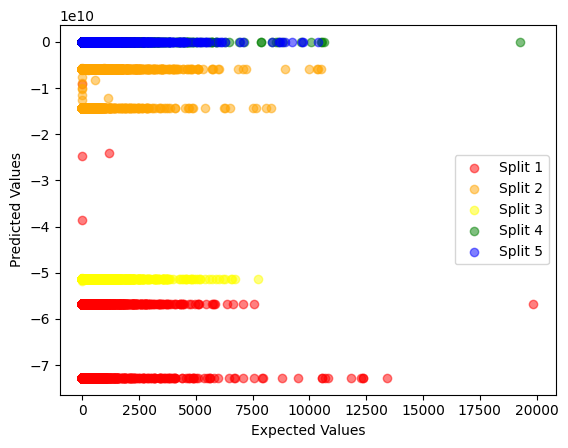

In [71]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Initialize lists to store train and test scores
train_scores = []
test_scores = []

# Initialize a list of colors for plotting
colors = ['red', 'orange', 'yellow', 'green', 'blue']

# Loop over each split
for i, (train_index, test_index) in enumerate(tscv.split(all_features)):
    # Split the data
    X_train, X_test = all_features.iloc[train_index], all_features.iloc[test_index]
    y_train, y_test = all_features['sales'].iloc[train_index], all_features['sales'].iloc[test_index]

    # Fit the pipeline on the training data
    pipeline.fit(X_train, y_train)

    # Get predictions for both the training and test data
    y_train_pred = pipeline.predict(X_train)
    y_test_pred = pipeline.predict(X_test)

    # Calculate and store the train and test scores
    train_scores.append(mean_squared_error(y_train, y_train_pred, squared=False))
    test_scores.append(mean_squared_error(y_test, y_test_pred, squared=False))

    # Plot the predicted vs expected values for the test data
    plt.scatter(y_test, y_test_pred, color=colors[i], alpha=0.5, label=f'Split {i+1}')

# Print the train and test scores
print('Train scores:', train_scores)
print('Test scores:', test_scores)

# Add labels and legend to the plot
plt.xlabel('Expected Values')
plt.ylabel('Predicted Values')
plt.legend()

# Show the plot
plt.show()


In [70]:
cross_val_predict_results = cross_val_predict(pipeline, all_features, all_features['sales'], cv=TimeSeriesSplit(n_splits=5))

ValueError: cross_val_predict only works for partitions

In [53]:
import sklearn
with sklearn.config_context(skip_parameter_validation=True):

    cross_val_results = cross_val_score(pipeline, cross_val_dataframes, cross_val_y_truth, cv=TimeSeriesSplit(n_splits=5))
    pipeline.fit(cross_val_dataframes, cross_val_y_truth)

    #The dataframe for outer validation
    outer_val_dataframes:TimeSeriesForecastDataframes = TimeSeriesForecastDataframes(entire_dataframes.base_xy_df[50000:100000],
                                                                                    entire_dataframes.stores_df,
                                                                                    entire_dataframes.oil_df,
                                                                                    entire_dataframes.transactions_df,
                                                                                    entire_dataframes.special_days_df)
    outer_val_y_truth:pd.Series = outer_val_dataframes.base_xy_df['sales']
    outer_val_score = pipeline.score(outer_val_dataframes, outer_val_y_truth)
    outer_val_predictions = pipeline.predict(outer_val_dataframes)
    outer_val_score_from_predictions = r2_score(outer_val_y_truth, outer_val_predictions)


    pipeline.score_samples()

    submission_dfs = TimeSeriesForecastDataframes(additionalDataframes.elements_to_predict_x_base_df,
                                                    entire_dataframes.stores_df,
                                                    entire_dataframes.oil_df,
                                                    entire_dataframes.transactions_df,
                                                    entire_dataframes.special_days_df)

    predictions = pipeline.predict(submission_dfs)

NameError: name 'cross_val_y_truth' is not defined

In [ ]:
# Outer validation predictions
plt.figure(figsize=(7, 5))
plt.plot(outer_val_y_truth.index, outer_val_y_truth, label='Truth')
plt.plot(outer_val_y_truth.index, outer_val_predictions, label='Predictions')
plt.title('Outer Validation Predictions')
plt.legend()
plt.show()
print(f'Outer validation score: {outer_val_score}')

# Future data predictions
plt.figure(figsize=(7, 5))
plt.plot(submission_dfs.base_xy_df.index, predictions, label='Predictions')
plt.title('Future Data Predictions')
plt.legend()
plt.show()

In [5]:
#This line and the next one could be inside objective trial if we wanted to tune those aswell.
#Create a preprocessing pipeline (without fitting it to anything)
pipeline = data_prep.create_pipeline(stores_df, oil_df, transactions_df, special_days_df, window_size=2, verbose=True) #El de date tardo mucho.



#A df containing both the current and the target values, considering this is time dataset. The question is how to split it.
#This dataframe contains the current features incluiding the store sales and the features with a certain lag named lag_N
processed_train_df:pd.DataFrame = pipeline.fit_transform(train_df[:100000], train_y_truth[:100000])

features_df = processed_train_df.drop('all_products_transactions')
target_df = processed_train_df['all_products_transactions']

scores = cross_val_score(pipeline, train_df, train_y_truth, cv=5)


#It seems that pipelines have fit, transform and predict method though so it might be unnecesary to separate them.


#import tensorflow as tf
#import keras
#from tqdm import tqdm

processed_elements_to_predict = pipeline.transform(elements_to_predict_df)



[Pipeline] .... (step 1 of 8) Processing rename_columns, total=   0.0s


[Pipeline] .. (step 2 of 8) Processing merge_dataframes, total=   0.4s
[Pipeline]  (step 3 of 8) Processing fill_missing_oil_values, total=   0.0s
[Pipeline]  (step 4 of 8) Processing refine_special_day_reason, total=   0.2s
[Pipeline]  (step 5 of 8) Processing replace_date_with_date_related_columns, total=   0.1s
[Pipeline] .. (step 6 of 8) Processing reorder_features, total=   0.0s
[Pipeline] .. (step 7 of 8) Processing prepare_features, total=   5.2s
[Pipeline] .... (step 8 of 8) Processing window_dataset, total=   1.3s


In [ ]:
from sklearn.model_selection import cross_val_score
import optuna

def objective(trial):
    # Define the hyperparameters
    hyperparams = { #When using pipelines, you need to prefix the parameters depending on which part of the pipeline they refer to with the name of the respective component
        'regressor__fit_intercept': trial.suggest_categorical('fit_intercept', [True, False]),
        'regressor__normalize': trial.suggest_categorical('normalize', [True, False]),
    }

    # Set the hyperparameters to the pipeline
    fold_pipeline = data_prep.create_pipeline().set_params(**hyperparams)

    # Perform cross-validation and return the mean score
    scores = cross_val_score(fold_pipeline, processed_train_df, train_y_truth, cv=5, scoring='neg_mean_squared_error')
    
    #Store additional results for the trial
    trial.set_user_attr('cv_scores', scores)

    return scores.mean()

sampler = optuna.samplers.TPESampler() #The TPESampler is a class in Optuna that implements the Tree-structured Parzen Estimator (TPE) algorithm, which is a kind of genetic algorithm.
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=5)

for i, trial in enumerate(study.trials):
    print(f'Trial {i}:')
    print(f'  Params: {trial.params}')
    print(f'  Scores: {trial.user_attrs["cv_scores"]}')

best_params = study.best_params
print(best_params)

pipeline = data_prep.create_pipeline().set_params(best_params)
#it could be a good idea here to do cv (maybe with cv_predict) and analyze the predictions during cv in order to find where it fails, and compare it to other models to make enssambles.
#Maybe what we could compare is the difference in the prediction for each value, and sum the difference in those diferences between the models.
#The number of models in the ensamble could be tuned in another trial.
#The weights in voting in the ensamble could be tuned in another trial.

pipeline.set_params(**best_params)
pipeline.fit(train_df, dataset_y)

predictions = pipeline.predict(elements_to_predict_df)


# Analyze the performance
# This part depends on what kind of analysis you want to do.
# For example, you can calculate the prediction error for each sample:
errors = target_df - pipeline.predict(features_df)

In [ ]:
from sklearn.model_selection import cross_val_score
import optuna

def objective(trial):
    # Define the hyperparameters
    hyperparams = { #When using pipelines, you need to prefix the parameters depending on which part of the pipeline they refer to with the name of the respective component
        'regressor__fit_intercept': trial.suggest_categorical('fit_intercept', [True, False]),
        'regressor__normalize': trial.suggest_categorical('normalize', [True, False]),
    }

    # Set the hyperparameters to the pipeline
    fold_pipeline = data_prep.create_pipeline().set_params(**hyperparams)

    # Perform cross-validation and return the mean score
    scores = cross_val_score(fold_pipeline, features_df, target_df, cv=5, scoring='neg_mean_squared_error')
    
    #Store additional results for the trial
    trial.set_user_attr('cv_scores', scores)

    return scores.mean()

sampler = optuna.samplers.TPESampler() #The TPESampler is a class in Optuna that implements the Tree-structured Parzen Estimator (TPE) algorithm, which is a kind of genetic algorithm.
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=5)

for i, trial in enumerate(study.trials):
    print(f'Trial {i}:')
    print(f'  Params: {trial.params}')
    print(f'  Scores: {trial.user_attrs["cv_scores"]}')

best_params = study.best_params
print(best_params)

pipeline = data_prep.create_pipeline().set_params(best_params)
#it could be a good idea here to do cv (maybe with cv_predict) and analyze the predictions during cv in order to find where it fails, and compare it to other models to make enssambles.
#Maybe what we could compare is the difference in the prediction for each value, and sum the difference in those diferences between the models.
#The number of models in the ensamble could be tuned in another trial.
#The weights in voting in the ensamble could be tuned in another trial.

pipeline.set_params(**best_params)
pipeline.fit(train_df, dataset_y)

predictions = pipeline.predict(elements_to_predict_df)


# Analyze the performance
# This part depends on what kind of analysis you want to do.
# For example, you can calculate the prediction error for each sample:
errors = target_df - pipeline.predict(features_df)